In [10]:
import numpy as np
from sklearn import datasets
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

BIDS_path= "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\"
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']


In [11]:
df_all = pd.read_csv("df_all.csv", index_col=0)

In [13]:
df_here_STN = df_all[df_all["loc"].str.contains("STN")]
df_here_ECOG = df_all[df_all["loc"].str.contains("ECOG")]
per_ = []
pred_ = []
for sub in subjects:
    sub_ = int(sub)
    per_.append(np.concatenate((df_here_ECOG[df_here_ECOG["sub"] == sub_]["r2_con"], \
                               df_here_ECOG[df_here_ECOG["sub"] == sub_]["r2_ips"], 
                         df_here_STN[df_here_STN["sub"] == sub_]["r2_con"], \
                               df_here_STN[df_here_STN["sub"] == sub_]["r2_ips"])).mean())

    pred_.append(df_here_ECOG[df_here_ECOG["sub"] == sub_]["UPDRS_total"].iloc[0]) 


df_comp = pd.DataFrame()
df_comp["r2"] = np.array(per_)
df_comp["pred"] = pred_
print(stats.spearmanr(df_comp["r2"], df_comp["pred"]))

model = smf.ols("r2~pred", data=df_comp)
results = model.fit()

print(results.summary())

SpearmanrResult(correlation=-0.6104799437547951, pvalue=0.046060398811002226)
                            OLS Regression Results                            
Dep. Variable:                     r2   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     3.990
Date:                Fri, 23 Oct 2020   Prob (F-statistic):             0.0769
Time:                        10:11:45   Log-Likelihood:                 10.089
No. Observations:                  11   AIC:                            -16.18
Df Residuals:                       9   BIC:                            -15.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

C:\Users\ICN_admin\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


### Step 1, metric chooses: MEAN

#### The two distributions are seaparared by a median split
#### Here the R^2 values are based on the mean of ECOG and STN, but will be any performance 

The only meaningful way to perform permutation test seems here splitting the distr. into two, based on the argsort order of the UPDRS 
Argsort: klein zu groß

In [28]:
arr_UPDRS_sorted = np.array(df_comp["r2"][np.argsort(df_comp["pred"])])

In [31]:
arr_UPDRS_sorted[:5], arr_UPDRS_sorted[6:]

(array([0.16680003, 0.42692879, 0.06712371, 0.01862607, 0.08808695]),
 array([0.02230378, 0.00990473, 0.00646169, 0.06215355, 0.02472174]))

#### 2. Step: compute ground truth, difference of the means

In [56]:
gT = np.abs(np.average(arr_UPDRS_sorted[:int(arr_UPDRS_sorted.shape[0]/2)]) - 
            np.average(arr_UPDRS_sorted[int(arr_UPDRS_sorted.shape[0]/2):]))

In [57]:
gT

0.11407034466907173

#### 3. Step: Pool variable into one distribution

In [58]:
pV = arr_UPDRS_sorted # this is the whole UPDRS sorted array here actually

#### 4. Step: Randomly sample (also called bootstrapping) without replacement two distributions with the size equal to the original distributions from this pooled distribution to compute the absolute difference RΔτ of your metric between your two permuted samples:

In [71]:
#Copy pooled distribution:
pS = copy.copy(pV)
#Initialize permutation:
pD = []
#Define p (number of permutations):
p=5000
# Permutation loop:
for i in range(0,p):
  # Shuffle the data:
    random.shuffle(pS)
    # Compute permuted absolute difference of your two sampled distributions and store it in pD:
    pD.append(np.abs(np.average(pS[0:int(len(pS)/2)]) - np.average(pS[int(len(pS)/2):])))

#### 5. Finally, the proportion of permuted differences higher than your ground truth difference is your significance value:

In [72]:
p_val = len(np.where(pD>=gT)[0])/p

In [73]:
p_val

0.071

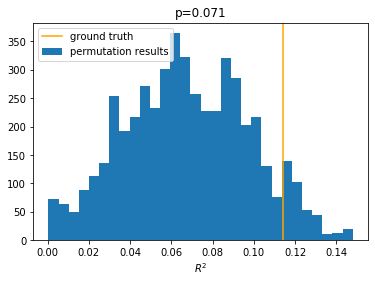

In [74]:
plt.hist(pD, bins=30,label="permutation results")
plt.axvline(gT, color="orange", label="ground truth")
plt.title("p="+str(p_val))
plt.xlabel(r"$R^2$")
plt.legend()
plt.show()

In [76]:
### Write this as a function 
def permutationTestMedianSplit(x, y, plot_=True, x_unit=None, p=5000):
    """
    Calculate permutation test
    https://towardsdatascience.com/how-to-assess-statistical-significance-in-your-data-with-permutation-tests-8bb925b2113d

    x (np array) : distribution that will be compared statistically e.g. R^2
    y (np array) : according ordinal values e.g. UPDRS
    plot_ (boolean) : if True: permutation histplot and ground truth will be potted
    x_unit (str) : histplot xlabel 
    p (int): number of permutations
    """
    
    # first, order y, and take respective values of x 
    arr_argsort = x[np.argsort(y)]
    
    # compute ground truth difference
    gT = np.abs(np.average(arr_argsort[:int(arr_argsort.shape[0]/2)]) - 
            np.average(arr_argsort[int(arr_argsort.shape[0]/2):]))
    
    # 
    pV = arr_argsort
    pS = copy.copy(pV)
    #Initialize permutation:
    pD = []
    # Permutation loop:
    for i in range(0,p):
      # Shuffle the data:
        random.shuffle(pS)
        # Compute permuted absolute difference of your two sampled distributions and store it in pD:
        pD.append(np.abs(np.average(pS[0:int(len(pS)/2)]) - np.average(pS[int(len(pS)/2):])))
    
    # calculate p value
    p_val = len(np.where(pD>=gT)[0])/p
    
    if plot_ is True:    
        plt.hist(pD, bins=30,label="permutation results")
        plt.axvline(gT, color="orange", label="ground truth")
        plt.title("p="+str(p_val))
        plt.xlabel(r"$R^2$")
        plt.legend()
        plt.show()
    return p_val

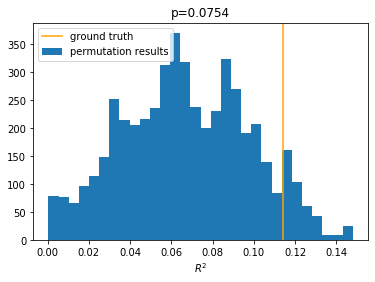

0.0754

In [78]:
permutationTestMedianSplit(x=np.array(df_comp["r2"]), y=np.array(df_comp["pred"]), plot_=True, x_unit=r"$R^2$")

In [79]:
### Now write a second version where two distributions are compared 
### Write this as a function 
def permutationTest(x, y, plot_=True, x_unit=None, p=5000):
    """
    Calculate permutation test
    https://towardsdatascience.com/how-to-assess-statistical-significance-in-your-data-with-permutation-tests-8bb925b2113d

    x (np array) : first distr.
    y (np array) : first distr.
    plot_ (boolean) : if True: permutation histplot and ground truth will be potted
    x_unit (str) : histplot xlabel 
    p (int): number of permutations
    """
    
    
    # compute ground truth difference
    gT = np.abs(np.average(x) - np.average(y))
    
    
    pV = np.concatenate((x,y), axis=0)
    pS = copy.copy(pV)
    #Initialize permutation:
    pD = []
    # Permutation loop:
    for i in range(0,p):
      # Shuffle the data:
        random.shuffle(pS)
        # Compute permuted absolute difference of your two sampled distributions and store it in pD:
        pD.append(np.abs(np.average(pS[0:int(len(pS)/2)]) - np.average(pS[int(len(pS)/2):])))
    
    # calculate p value
    p_val = len(np.where(pD>=gT)[0])/p
    
    if plot_ is True:    
        plt.hist(pD, bins=30,label="permutation results")
        plt.axvline(gT, color="orange", label="ground truth")
        plt.title("p="+str(p_val))
        plt.xlabel(r"$R^2$")
        plt.legend()
        plt.show()
    return p_val

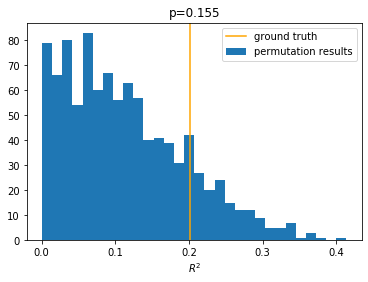

0.155

In [81]:
permutationTest(np.random.random(10), np.random.random(10), True, "keine", 1000)